In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
import torchvision.models as models


import os
import numpy as np
import librosa
import os
import torch
import torchaudio.transforms as T
import datetime
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

#import own modules
import config
from utils_dir import transforms 

#empty cache
torch.cuda.empty_cache()


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")



In [2]:
if config.ESC_50:
    from DL_pretrain import ESC_50_DL_pretrain as DS
    print("ESC_50 Loaded for pretraining")
    Data_name = "ESC_50"
if config.US8K:
    from DL_pretrain import US8k_DL_pretrain as DS
    print("US8K Loaded for pretraining")
    Data_name = "US8K"
if config.ADSMI:
    from DL_pretrain import ADSMI_DL_pretrain as DS
    print("ADSMI Loaded for pretraining")
    Data_name = "ADSMI"



ADSMI Loaded for pretraining


Shape of tensors in triplet 1:
Anchor:			torch.Size([1, 128, 431])
Positive:		torch.Size([1, 128, 431])
Negative:		torch.Size([1, 128, 431])
False
False


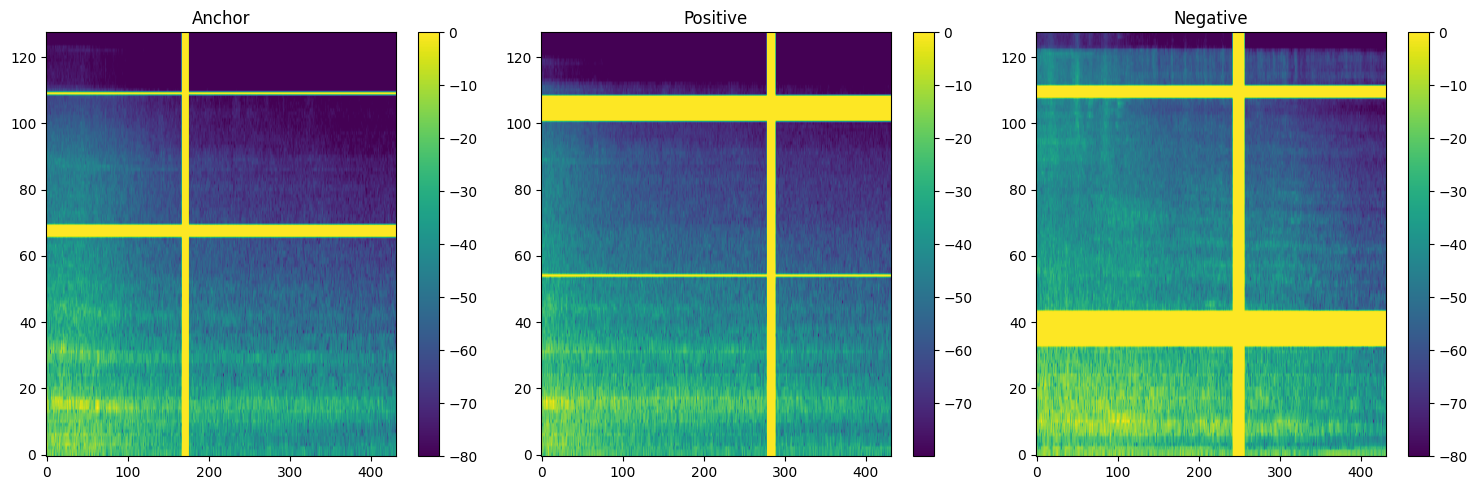

3


In [4]:
config.channels = 1
train_dataset = DS.AudioDataset(train=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

if config.channels == 1:
    def plot_triplet_spectrogram(train_loader, n_triplets=1):
        """
        Plot spectrograms for anchor, positive and negative from the first batch of the given loader.
        
        Args:
        - train_loader (torch.utils.data.DataLoader): Data loader for triplet data.
        """
        # Fetch the first batch
        data_iter = iter(train_loader)
        anchor, positive, negative = data_iter.__next__()

        # Function to plot spectrogram
        def plot_spectrogram(spectrogram, ax, title):
            im = ax.imshow(spectrogram.squeeze().cpu().numpy(), aspect='auto', origin='lower')
            ax.set_title(title)
            fig.colorbar(im, ax=ax)
        
        

        i = 0
        for i in range(n_triplets):
            # Print shape of tensors
            print("Shape of tensors in triplet {0}:".format(i+1))
            print("Anchor:\t\t\t{0}\nPositive:\t\t{1}\nNegative:\t\t{2}".format(anchor[i].shape, positive[i].shape, negative[i].shape))
            print(torch.equal(anchor[i], positive[i]))
            print(torch.allclose(anchor[i], positive[i], atol=1e-6))

            # Plot the first triplet
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            plot_spectrogram(anchor[i], axes[0], "Anchor")
            plot_spectrogram(positive[i], axes[1], "Positive")
            plot_spectrogram(negative[i], axes[2], "Negative")
            plt.tight_layout()
            plt.show()
        config.channels = 3
    # Example usage:
    plot_triplet_spectrogram(train_loader)
    print(config.channels)


import matplotlib.pyplot as plt
import numpy as np

def rescale_data(data):
    return (data - data.min()) / (data.max() - data.min())


def plot_triplet_spectrogram(train_loader, n_triplets=1):
    """
    Plot RGB spectrograms for anchor, positive and negative from the first batch of the given loader.
    
    Args:
    - train_loader (torch.utils.data.DataLoader): Data loader for triplet data.
    """
    # Fetch the first batch
    data_iter = iter(train_loader)
    anchor, positive, negative = data_iter.__next__()

    # Function to plot RGB spectrogram
    def plot_spectrogram(spectrogram, ax, title):
        # Assume spectrogram has shape (3, Height, Width) representing (C, H, W)
        # Convert to numpy and transpose to (H, W, C) for visualization
        im = ax.imshow(np.transpose(rescale_data(spectrogram.numpy()), (1, 2, 0)))

        ax.set_title(title)
        fig.colorbar(im, ax=ax)
    
    for i in range(n_triplets):
        # Print shape of tensors
        print("Shape of tensors in triplet {0}:".format(i+1))
        print("Anchor:\t\t\t{0}\nPositive:\t\t{1}\nNegative:\t\t{2}".format(anchor[i].shape, positive[i].shape, negative[i].shape))
        print(torch.equal(anchor[i], positive[i]))
        print(torch.allclose(anchor[i], positive[i], atol=1e-6))

        # Plot the first triplet
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        plot_spectrogram(anchor[i], axes[0], "Anchor")
        plot_spectrogram(positive[i], axes[1], "Positive")
        plot_spectrogram(negative[i], axes[2], "Negative")
        plt.tight_layout()
        plt.show()

# Example usage:
plot_triplet_spectrogram(train_loader)


In [5]:

class ContrastiveTripletLoss(nn.Module):
    def __init__(self, margin=0.5, temperature=0.07):
        super(ContrastiveTripletLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        Args:
        - anchor: Embeddings from log_s_po_aug1
        - positive: Embeddings from log_s_po_aug2
        - negative: Embeddings from log_s_neg_aug1

        Returns:
        - A loss scalar.
        """
        # Compute similarities
        pos_sim = F.cosine_similarity(anchor, positive) / self.temperature
        neg_sim = F.cosine_similarity(anchor, negative) / self.temperature

        # Compute the triplet loss
        losses = F.relu(self.margin - pos_sim + neg_sim)

        return losses.mean()

In [6]:

class ContrastiveTripletLoss(nn.Module):
    def __init__(self, margin=0.5, temperature=0.07):
        super(ContrastiveTripletLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        Args:
        - anchor: Embeddings from log_s_po_aug1
        - positive: Embeddings from log_s_po_aug2
        - negative: Embeddings from log_s_neg_aug1

        Returns:
        - A loss scalar.
        """
        # L2 normalize the embeddings
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute similarities
        pos_sim = F.cosine_similarity(anchor, positive) / self.temperature
        neg_sim = F.cosine_similarity(anchor, negative) / self.temperature

        # Compute the triplet loss
        losses = F.relu(self.margin - pos_sim + neg_sim)

        return losses.mean()

# Triplet Model without dropout layer



import torchvision.models as models

# Triplet Model without dropout layer

class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        # Assuming your data is a spectrogram of shape [128, X]. 
        # ResNet50 expects 3-channel inputs, so let's adapt the first layer.
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3


# Model with PH

In [7]:
print(config.channels)

class ContrastiveTripletModel(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer (with 50% probability, adjust as needed)
        #self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


# Model without PH but Dropout

import torchvision.models as models
import torch.nn as nn

# contrastive triplet model with resnet50 without dropout

class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Modifications for your dataset:
        # Assuming your data is a spectrogram of shape [128, X]. 
        # ResNet50 expects 3-channel inputs, so let's adapt the first layer.
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Dropout layer (with 50% probability, adjust as needed)
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3


In [ ]:

patience = 30  # or whatever value you deem appropriate
early_stop_counter = 0



print(config.epochs)
print(config.batch_size)


# Initialization
model = ContrastiveTripletModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = ContrastiveTripletLoss()

# Data
train_loader, test_loader = DS.create_generators()

epochs = config.epochs
training_losses = []
validation_losses = []

# Create log directory
current_date = datetime.datetime.now().strftime('%Y-%m-%d-%H')
log_dir = f"./results/CLR-{current_date}-epochs-{epochs}-{Data_name}"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Log file path
log_file_path = os.path.join(log_dir, "training_log.txt")

best_loss = float('inf')

# Training and Validation loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_loader), total=len(train_loader)):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        optimizer.zero_grad()

        anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)

        loss = criterion(anchor_repr, positive_repr, negative_repr)
        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_loader), total=len(test_loader)):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
            loss = criterion(anchor_repr, positive_repr, negative_repr)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Log to file
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        print("Validation Loss improved! Checkpointing the model...")
        torch.save(model, os.path.join(log_dir, f"checkpoint.pth"))  # Modified this line
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Validation Loss improved at Epoch {epoch+1}.\n")
        early_stop_counter = 0  # reset counter
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print("Early stopping!")
        break

# Plot training and validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()
